# 12 Hands-on: Normalizing Flows

Apresentar algumas implementações de bijetores, e como concatená-los para formar um flow. Usaremos o `tensorflow_probability`.

In [39]:
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
from time import time

In [132]:
#@title Funções auxiliares
def make_samples(base, trainable_dist):
    x = base.sample(1000)
    samples = [x]
    names = [base.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            
            idx = np.logical_and(X < 0, Y < 0)
            arr[r,c].scatter(X[idx], Y[idx], s=10, color='red')
            idx = np.logical_and(X > 0, Y < 0)
            arr[r,c].scatter(X[idx], Y[idx], s=10, color='blue')
            idx = np.logical_and(X < 0, Y > 0)
            arr[r,c].scatter(X[idx], Y[idx], s=10, color='k')
            idx = np.logical_and(X > 0, Y > 0)
            arr[r,c].scatter(X[idx], Y[idx], s=10, color='g')
            p.set_xlim([X.min()-0.1, X.max()+0.1])
            p.set_ylim([Y.min()-0.1, Y.max()+0.1])
            p.set_title(names[i])
            
            i += 1
    plt.show()

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(pts), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_title(names[i])


In [40]:
tfd = tfp.distributions
tfb = tfp.bijectors

## 1. Distribuições e bijetores

O tensorflow probability já vem com diversas distribuições e bijetores prontos para uso.

### A. Distribuições

In [41]:
base = tfd.MultivariateNormalDiag(loc=[0., 0.])

(10000, 2)


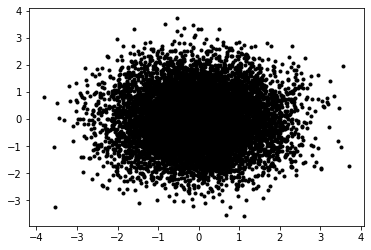

In [120]:
samples = base.sample(10000).numpy()
print(samples.shape)
plt.plot(samples[:,0], samples[:,1], 'k.')
plt.show()

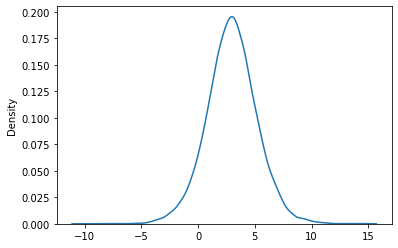

In [114]:
student = tfd.StudentT(df=10, loc=3, scale=2)
samples = student.sample(10000)

sns.kdeplot(x=samples)
plt.show()

### Poisson:

#### $pmf(X=k) = \frac{\lambda^k\exp(-\lambda)}{k!}$

k = número de possíveis occorrências

$\lambda$ = taxa de ocorrência

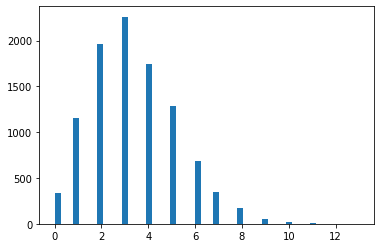

In [109]:
poisson = tfd.Poisson(rate=3.4)
samples = poisson.sample(10000)
plt.hist(samples, 50)
plt.show()

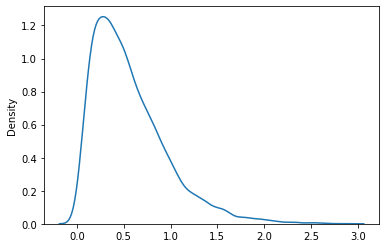

In [116]:
gamma = tfd.Gamma(concentration=2.0, rate=3.5)
samples = gamma.sample(10000)
sns.kdeplot(x=samples)
plt.show()

### B. Bijetores

Além de possuir uma série de bijetores diferentes, podemos criar novos e customizados através da classe `tfb.Bijector`

In [130]:
exp = tfb.Exp()
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=exp
)

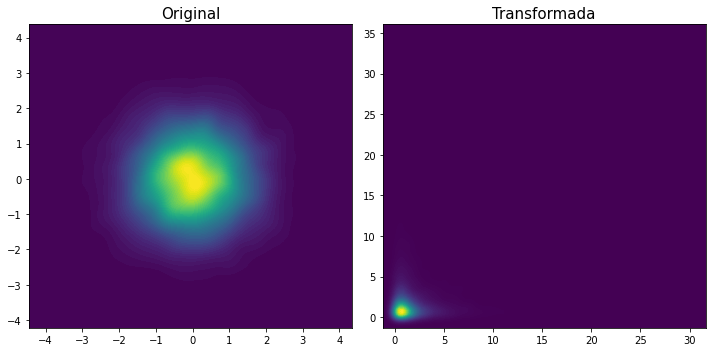

In [131]:
samples_t = dist.sample(10000)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, levels=20, cmap='viridis', thresh=0, ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, levels=20, cmap='viridis', thresh=0, ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

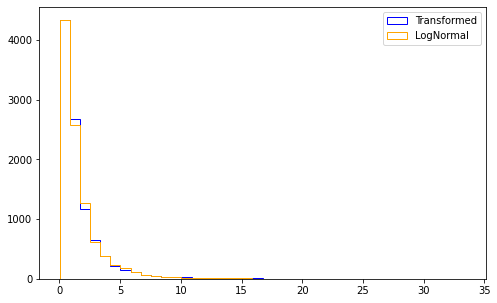

In [17]:
lognorm = tfd.LogNormal(loc=0.0, scale=1.0)
s = lognorm.sample(10000).numpy()
plt.figure(figsize=[8,5])
c, bins, _ = plt.hist(samples_t[:,0], 40, histtype='step', color='b', label='Transformed')
plt.hist(s, bins, histtype='step', color='orange', label='LogNormal')
plt.legend(loc='upper right')
plt.show()

In [118]:
sigmoid = tfb.Sigmoid()
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=sigmoid
)

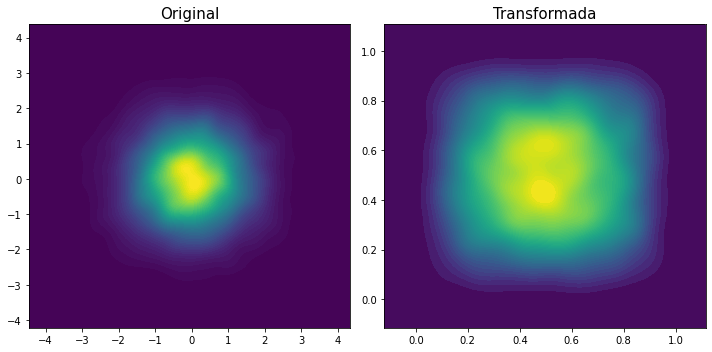

In [121]:
samples_t = dist.sample(10000)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, levels=60, cmap='viridis', thresh=0, ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, levels=60, cmap='viridis', thresh=0, ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

In [124]:
tanh = tfb.Tanh()
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=tanh
)

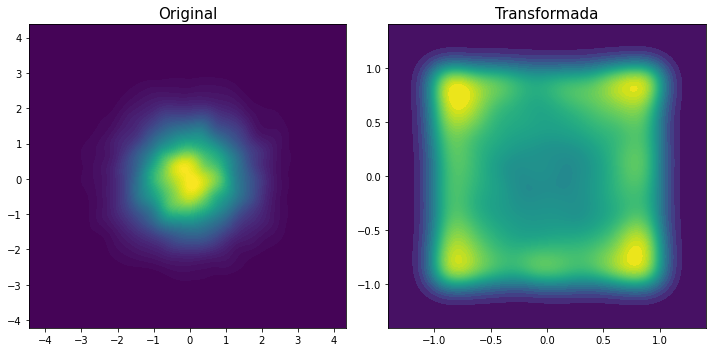

In [125]:
samples_t = dist.sample(10000)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, levels=60, cmap='viridis', thresh=0, ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, levels=60, cmap='viridis', thresh=0, ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

In [126]:
class ScaleAndShift(tfb.Bijector):
    def __init__(self, mu=0.0, sigma=0.0, validate_args=False, name="exp"):
        super(ScaleAndShift, self).__init__(
          validate_args=validate_args,
          forward_min_event_ndims=0,
          name=name)
        self.mu = mu
        self.sigma = sigma

    def forward(self, x):
        # Calling forward
        return x * self.sigma + self.mu

    def _inverse(self, y):
        return (y - self.mu) / self.sigma

    def _inverse_log_det_jacobian(self, y):
        return -self._forward_log_det_jacobian(self._inverse(y))

    def _forward_log_det_jacobian(self, x):
      # Notice that we needn't do any reducing, even when`event_ndims > 0`.
      # The base Bijector class will handle reducing for us; it knows how
      # to do so because we called `super` `__init__` with
      # `forward_min_event_ndims = 0`.
        return tf.log(self.sigma)

In [127]:
scale_shift = ScaleAndShift(2.0, 1.0)
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=scale_shift
)

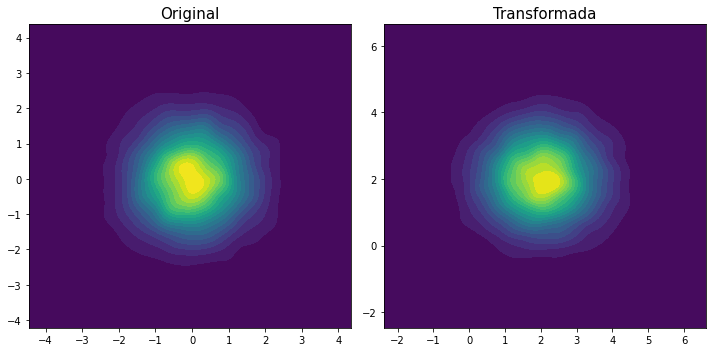

In [129]:
samples_t = dist.sample(10000)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, levels=20, cmap='viridis', thresh=0, ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, levels=20, cmap='viridis', thresh=0, ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

In [19]:
class PlanarFlow(tfb.Bijector, tf.Module):
    '''
    Implementation of Planar Flow for sampling and density estimation.
    Attributes:
        input_dimensions (int): Dimensions of the input samples.
        case (str): 'density_estimation' or 'sampling'.
    '''

    def __init__(self, input_dimensions, case="density_estimation", validate_args=False, name="planar_flow"):
        super(PlanarFlow, self).__init__(
            forward_min_event_ndims=1,
            inverse_min_event_ndims=1,
            validate_args=validate_args,
            name=name)

        self.event_ndims = 1
        self.case = case

        try:
            assert self.case != "density_estimation" or self.case != "sampling"
        except ValueError:
            print("Case is not defined. Available options for case: density_estimation, sampling")

        self.u = tf.Variable(np.random.uniform(-1., 1., size=(int(input_dimensions))), name='u', dtype=tf.float32, trainable=True)
        self.w = tf.Variable(np.random.uniform(-1., 1., size=(int(input_dimensions))), name='w', dtype=tf.float32, trainable=True)
        self.b = tf.Variable(np.random.uniform(-1., 1., size=(1)), name='b', dtype=tf.float32, trainable=True)


    def h(self, y):
        return tf.math.tanh(y)

    def h_prime(self, y):
        return 1.0 - tf.math.tanh(y) ** 2.0

    def alpha(self):
        wu = tf.tensordot(self.w, self.u, 1)
        m = -1.0 + tf.nn.softplus(wu)
        return m - wu

    def _u(self):
        if tf.tensordot(self.w, self.u, 1) <= -1:
            alpha = self.alpha()
            z_para = tf.transpose(alpha * self.w / tf.math.sqrt(tf.reduce_sum(self.w ** 2.0)))
            self.u.assign_add(z_para)  # self.u = self.u + z_para

    def _forward_func(self, zk):
        inter_1 = self.h(tf.tensordot(zk, self.w, 1) + self.b)
        return tf.add(zk, tf.tensordot(inter_1, self.u, 0))

    def _forward(self, zk):
        if self.case == "sampling":
            return self._forward_func(zk)
        else:
            raise NotImplementedError('_forward is not implemented for density_estimation')

    def _inverse(self, zk):
        if self.case == "density_estimation":
            return self._forward_func(zk)
        else:
            raise NotImplementedError('_inverse is not implemented for sampling')
            
    def _log_det_jacobian(self, zk):
        psi = tf.tensordot(self.h_prime(tf.tensordot(zk, self.w, 1) + self.b), self.w, 0)
        det = tf.math.abs(1.0 + tf.tensordot(psi, self.u, 1))
        return tf.math.log(det)

    def _forward_log_det_jacobian(self, zk):
        if self.case == "sampling":
            return -self._log_det_jacobian(zk)
        else:
            raise NotImplementedError('_forward_log_det_jacobian is not implemented for density_estimation')

    def _inverse_log_det_jacobian(self, zk):
        return self._log_det_jacobian(zk)

In [20]:
planar = PlanarFlow(2, case='sampling')

In [21]:
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=planar
)

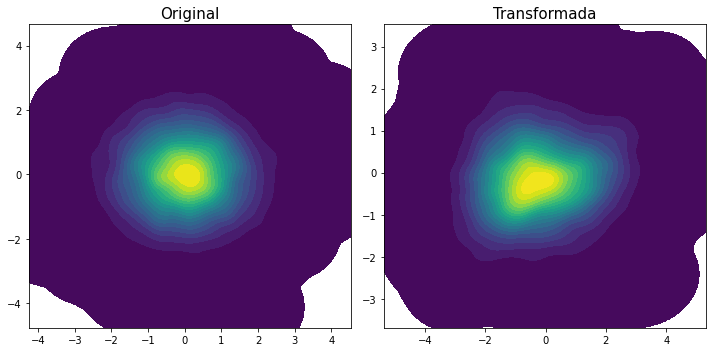

In [23]:
samples_t = dist.sample(10000)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, thresh=0, levels=20, cmap='viridis', ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, thresh=0, levels=20, cmap='viridis', ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

In [49]:
class RadialFlow(tfb.Bijector, tf.Module):
    

    def __init__(self, validate_args=False, event_ndims=0, name='radial'):
        super(RadialFlow, self).__init__(
          validate_args=validate_args,
          forward_min_event_ndims=event_ndims,
          name=name)
        self.event_ndims = event_ndims
        self.x0 = tf.Variable(np.random.uniform(0.01, 1., size=(1, self.event_ndims)), name='u', dtype=tf.float32)
        self.alpha = tf.Variable(np.random.uniform(0.01, 2., size=(1, self.event_ndims)), name='alpha', dtype=tf.float32)
        self.beta = tf.Variable(np.random.uniform(-2., 2., size=(1, self.event_ndims)), name='beta', dtype=tf.float32)      
        
    def _forward(self, x):
        """
        Given x, returns z and the log-determinant log|df/dx|.
        """
        r = tf.norm(x - self.x0)
        h = 1/(self.alpha + r)
        return x + self.beta*h*(x-self.x0)
        
    def _inverse(self, y):
        raise NotImplementedError('missing implementation of _inverse')

    def _forward_log_det_jacobian(self, z):
        raise NotImplementedError('missing implementation of _inverse')

    def _inverse_log_det_jacobian(self, y):
        raise NotImplementedError('missing implementation of _inverse_log_det_jacobian')
        #return -self._forward_log_det_jacobian(self.inverse(y))

In [50]:
radial = RadialFlow(event_ndims=2)
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=radial
)
samples_t = dist.sample(10000)

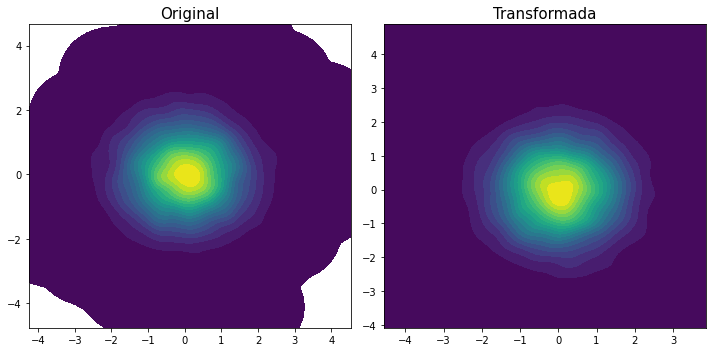

In [51]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, thresh=0, levels=20, cmap='viridis', ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, thresh=0, levels=20, cmap='viridis', ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

## 2. Flows

Vamos criar agora o flow, concatenando diferentes bijetores (podem ser da mesma família). 

In [58]:
bijs_planar = []
n_flows = 5
for i in range(n_flows):
  bijs_planar.append(PlanarFlow(2, case='sampling'))

In [59]:
planar_flow = tfb.Chain(list(reversed(bijs_planar)))

dist_planar = tfd.TransformedDistribution(
    distribution=base,
    bijector=planar_flow
)

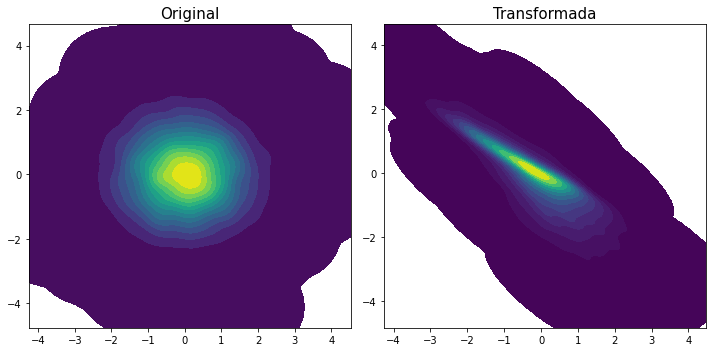

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,5])
samples_t = dist_planar.sample(10000)
sns.kdeplot(x=samples[:,0], y=samples[:,1], fill=True, thresh=0, levels=15, cmap='viridis', ax=ax1)
ax1.set_title('Original', fontsize=15)
sns.kdeplot(x=samples_t[:,0], y=samples_t[:,1], fill=True, thresh=0, levels=15, cmap='viridis', ax=ax2)
ax2.set_title('Transformada', fontsize=15)
plt.tight_layout()
plt.show()

## 3. Treinar um flow para aproximar uma distribuição complicada

In [5]:
!wget -O ber.png 'https://www.dropbox.com/s/ord1lpcvady84uj/ber.png?dl=0'

--2023-02-03 00:45:08--  https://www.dropbox.com/s/ord1lpcvady84uj/ber.png?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ord1lpcvady84uj/ber.png [following]
--2023-02-03 00:45:08--  https://www.dropbox.com/s/raw/ord1lpcvady84uj/ber.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc23292059ffef7352c681b0f3ec.dl.dropboxusercontent.com/cd/0/inline/B1xFtPFONDGCxZHvMRmWpYN8w-DZPnDQjsjpywKZna0MsyHvk8rl3MVi8lkREma6sO6-VCKDVC4i0recYBCO9XoIBoWxf4qVKDJHnJG_fd-LCB1Lb5Vtnd770T0Lsn3KcI0uq17hjp-pvTeEx48bbIBbr-IkRgbL4ByQjv_AbiFNzg/file# [following]
--2023-02-03 00:45:08--  https://uc23292059ffef7352c681b0f3ec.dl.dropboxusercontent.com/cd/0/inline/B1xFtPFONDGCxZHvMRmWpYN8w-DZPnDQjsjpywKZna0MsyHvk8rl3MVi8lkREma6sO6-VCKDVC4i0recYBCO9Xo

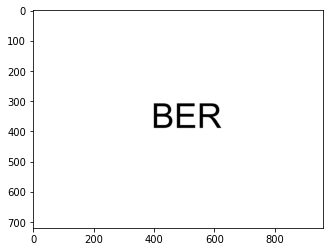

In [6]:
im = Image.open('ber.png')
plt.imshow(np.asarray(im))
plt.show()

In [11]:
arr = np.array(im)
max2 = np.max(arr, axis=2)
pts = []
w, h = max2.shape
while len(pts) < 10000:
    pt = np.random.rand(2).astype('f')
    x = int((1 - pt[0]) * w)
    y = int((pt[1]) * h)
    if max2[x,y] > 0:
        pts.append(pt)
pts = np.array(pts)
pts -= np.mean(pts, axis=0)
#pts *= 5
pts.shape

(10000, 2)

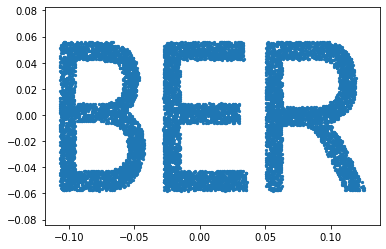

In [12]:
plt.scatter(pts[:,1], pts[:,0], s=5)
plt.axis('equal')
plt.show()

In [13]:
pts[:,[0,1]] = pts[:,[1,0]]

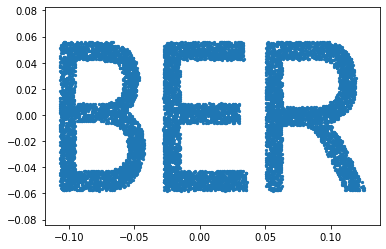

In [14]:
plt.scatter(pts[:,0], pts[:,1], s=5)
plt.axis('equal')
plt.show()

### A. Real NVP

In [60]:
class NN(tf.keras.layers.Layer):
    def __init__(self, input_shape, n_hidden=[512, 512], activation="relu", name="nn"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for i, hidden in enumerate(n_hidden):
            layer_list.append(tf.keras.layers.Dense(hidden, activation=activation, name='dense_{}_1'.format(i)))
            layer_list.append(tf.keras.layers.Dense(hidden, activation=activation, name='dense_{}_2'.format(i)))
        self.layer_list = layer_list
        self.log_s_layer = tf.keras.layers.Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = tf.keras.layers.Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t


class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        # this bijector do vector wise quantities.
        forward_min_event_ndims=1,
        validate_args: bool = False,
        name="real_nvp",
        nn_name='nn'
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
                          
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.layers.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = tf.keras.models.Model(x, [log_s, t], name=nn_name)

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return log_s

In [90]:
trainable_dist = tfd.TransformedDistribution(distribution=base, bijector=flow_bijector)
trainable_dist

<tfp.distributions._TransformedDistribution 'chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [85]:
#names, samples = make_samples()
#_plot(samples)

In [75]:
num_realnvp = 12
bijector_chain = []
for i in range(num_realnvp):
    bijector_chain.append(RealNVP(input_shape=[2], n_hidden=[256, 256], name=f"NVP_{i}", nn_name=f"nn_{i}"))
    bijector_chain.append(tfp.bijectors.Permute([1, 0]))

flow = tfd.TransformedDistribution(
    distribution=base,
    bijector=tfb.Chain(list(reversed(bijector_chain)))
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

trainable_variables:  144


In [16]:
def train_dist_routine(trainable_distribution, X_data, n_epochs=200, batch_size=1500, n_disp=100):
    x_ = tf.keras.layers.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = tf.keras.models.Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.1,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [76]:
history = train_dist_routine(flow, pts, n_epochs=1500, n_disp=50)


 Epoch 1/1500 
	 loss: 1.8365, val_loss: 1.8249

 Epoch 51/1500 
	 loss: -2.2891, val_loss: -2.3090

 Epoch 101/1500 
	 loss: -3.0960, val_loss: -3.0801

 Epoch 151/1500 
	 loss: -3.2121, val_loss: -3.2116

 Epoch 201/1500 
	 loss: -3.2921, val_loss: -3.2839

 Epoch 251/1500 
	 loss: -3.3453, val_loss: -3.3381

 Epoch 301/1500 
	 loss: -3.3872, val_loss: -3.3729

 Epoch 351/1500 
	 loss: -3.4262, val_loss: -3.4145

 Epoch 401/1500 
	 loss: -3.4610, val_loss: -3.4512

 Epoch 451/1500 
	 loss: -3.4964, val_loss: -3.4863

 Epoch 501/1500 
	 loss: -3.5330, val_loss: -3.5204

 Epoch 551/1500 
	 loss: -3.5842, val_loss: -3.5582

 Epoch 601/1500 
	 loss: -3.6178, val_loss: -3.5882

 Epoch 651/1500 
	 loss: -3.6426, val_loss: -3.5960

 Epoch 701/1500 
	 loss: -3.6633, val_loss: -3.6265

 Epoch 751/1500 
	 loss: -3.6804, val_loss: -3.6376

 Epoch 801/1500 
	 loss: -3.6925, val_loss: -3.6545

 Epoch 851/1500 
	 loss: -3.7111, val_loss: -3.6724

 Epoch 901/1500 
	 loss: -3.7200, val_loss: -3.689

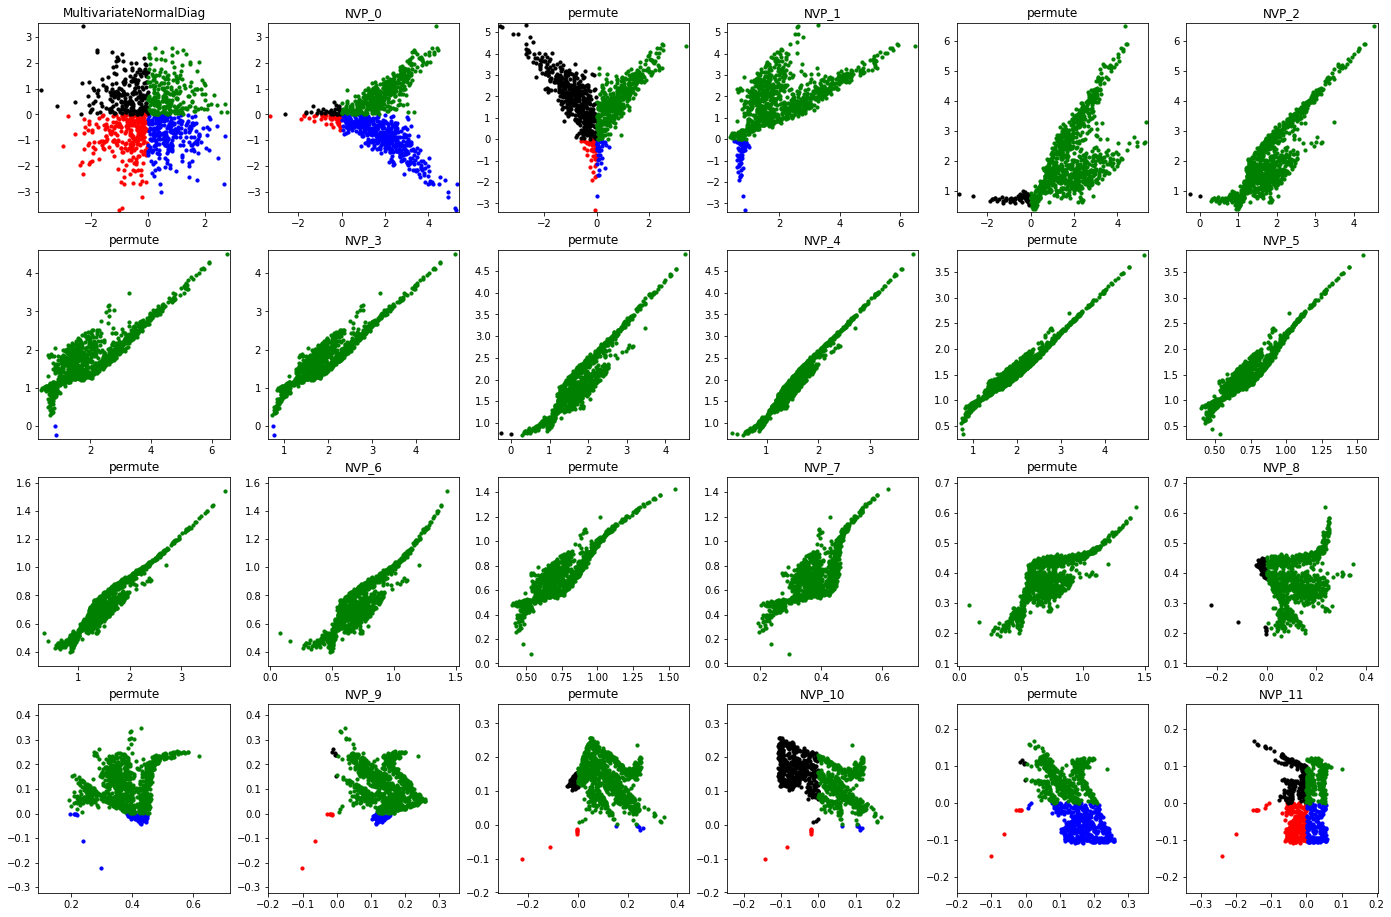

In [87]:
names, samples = make_samples(base, flow)
_plot(samples, 4)

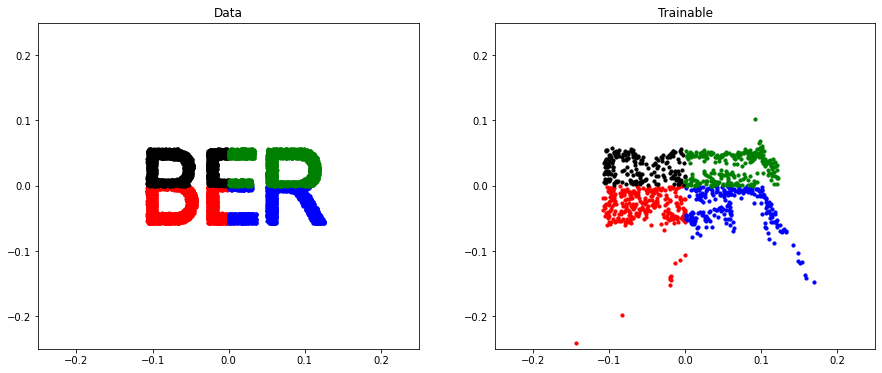

In [88]:
visualize_training_data(samples)

In [89]:
def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
num_bijectors = 10
bijectors = []

for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[512, 512], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1, 0]))
    
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))
trainable_dist = tfd.TransformedDistribution(distribution=base, bijector=flow_bijector)

In [91]:
history = train_dist_routine(trainable_dist, pts, n_epochs=1500, n_disp=100)


 Epoch 1/1500 
	 loss: 1.8201, val_loss: 1.8086

 Epoch 101/1500 
	 loss: -2.9376, val_loss: -2.9312

 Epoch 201/1500 
	 loss: -3.1072, val_loss: -3.0851

 Epoch 301/1500 
	 loss: -3.2693, val_loss: -3.2626

 Epoch 401/1500 
	 loss: -3.3764, val_loss: -3.3795

 Epoch 501/1500 
	 loss: -3.4334, val_loss: -3.4428

 Epoch 601/1500 
	 loss: -3.4786, val_loss: -3.4853

 Epoch 701/1500 
	 loss: -3.4985, val_loss: -3.5008

 Epoch 801/1500 
	 loss: -3.5179, val_loss: -3.5231

 Epoch 901/1500 
	 loss: -3.5294, val_loss: -3.5390

 Epoch 1001/1500 
	 loss: -3.5555, val_loss: -3.5661

 Epoch 1101/1500 
	 loss: -3.5702, val_loss: -3.5773

 Epoch 1201/1500 
	 loss: -3.5764, val_loss: -3.5826

 Epoch 1301/1500 
	 loss: -3.5867, val_loss: -3.5961

 Epoch 1401/1500 
	 loss: -3.6005, val_loss: -3.6065


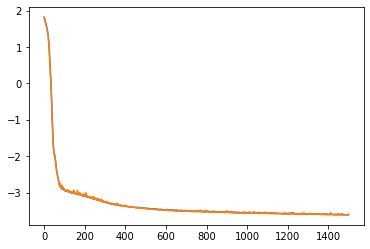

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

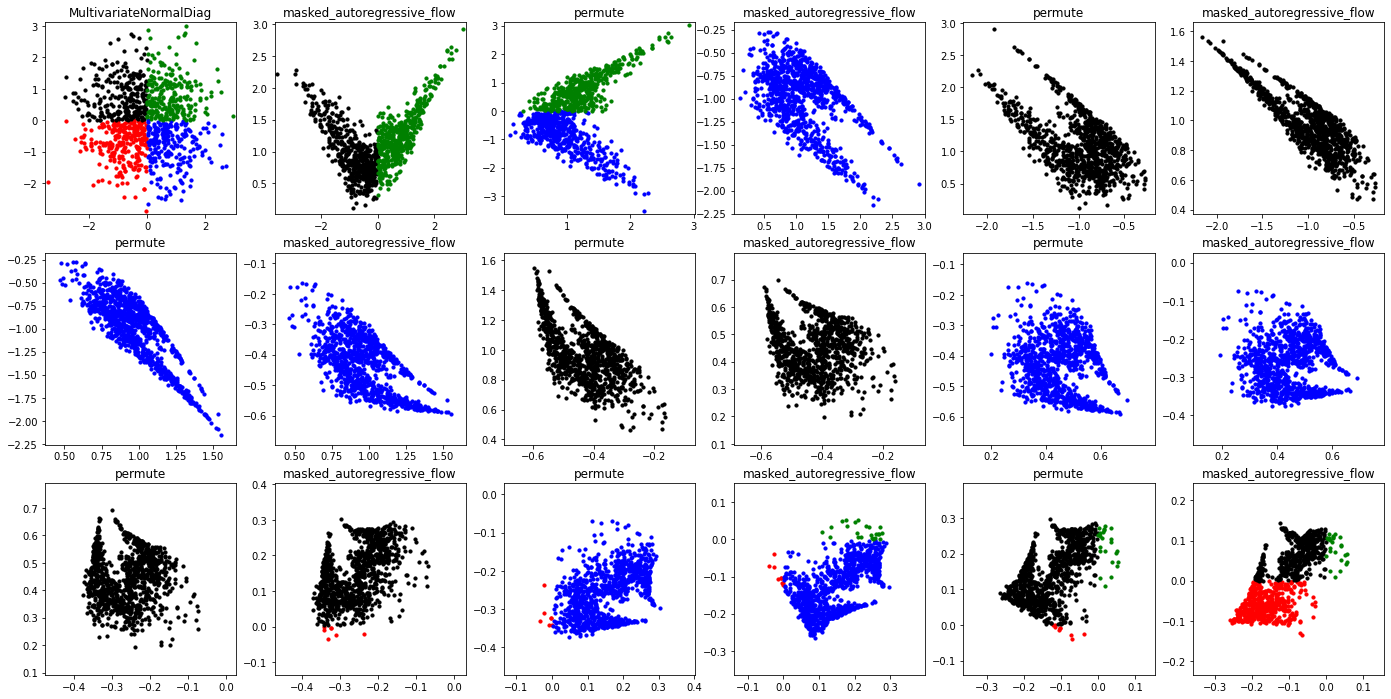

In [94]:
names, samples = make_samples(base, trainable_dist)
_plot(samples, 3)

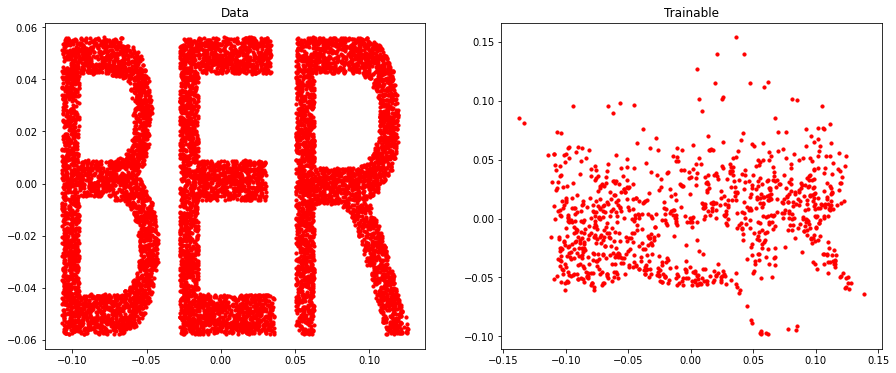

In [97]:
visualize_training_data(samples)

Exercícios:

1. Implementar um novo bijetor. Sugestão: rotação
1. Melhorar o resultado com os flows atuais
1. Tentar outro tipo flow (GLOW por exemplo)
